# Import Libraries, Load Data

### Imports

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

### Setting up Data

In [2]:
# # # Paths:
# price_path = "/Users/amilamuthunayake/Documents/Trading_Research/correlation_matrix_spectral_clustering/get_shardar_all_equity_based_on_cap/price_data_from_shardar.csv"
# cap_path = "/Users/amilamuthunayake/Documents/Trading_Research/correlation_matrix_spectral_clustering/get_shardar_all_equity_based_on_cap/cap_data_from_shardar.csv"
price_path = "C:/Users/Owner/school/math4920/price_data_from_shardar.csv"
cap_path = "C:/Users/Owner/school/math4920/cap_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [3]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
# df_diff = prices_with_market.diff().dropna()

[*********************100%***********************]  1 of 1 completed


# Functions

## Helper Functions

In [4]:
# Function to find the top ten largest market cap stocks
def find_top_liquid_stocks(date_end, num_stocks):
    global caps_df
    selected_row = caps_df.iloc[date_end]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(num_stocks).index.tolist()
    return stocks_list

In [5]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    filtered_df = filtered_df.dropna()
    return filtered_df

In [6]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [7]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    #res_df = pd.DataFrame()
    res_df = {}
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    res_df = pd.DataFrame(res_df)
    return res_df

In [8]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict

In [9]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          if pvalue1 < sig_level:
            pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
            if pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [10]:
# Function to find the cointegrated pairs
from statsmodels.tsa.stattools import adfuller
def find_cointegrated_pairs_manual(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          reg_coe = np.cov(dataframe[stock1], dataframe[stock2])[0, 1]/np.std(dataframe[stock2])
          res = dataframe[stock1] - reg_coe*dataframe[stock2]
          pvalue1 = adfuller(res)[1]
          if pvalue1 < sig_level:
            reg_coe = np.cov(dataframe[stock2], dataframe[stock1])[0, 1]/np.std(dataframe[stock1])
            res = dataframe[stock2] - reg_coe*dataframe[stock1]
            pvalue2 = adfuller(res)[1]
            if pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [11]:
# Function to check on existing pairs
def is_still_cointegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [12]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return math.floor(beta*100)/100

In [13]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')
        
    # print(dataframe[stocks_list])

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [14]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, mean

## Main Functions

In [15]:
def monitor_pair_for_day(window_size, stock_pair, pair_dictionary, current_day, currently_trading_stocks, spread_return_percentages, trade_close_dates, number_trades_allowed):
    
    global trade_open_dates, open_num_trades, prices_with_market

    num_op_trades = len(currently_trading_stocks)/2

    past_window_data = prices_with_market[current_day - window_size : current_day+1]

    dtype_day = past_window_data.index[-1]
    date = dtype_day.strftime('%Y-%m-%d')

    stock1_last_price = past_window_data[stock_pair[0]].dropna().iloc[-1]
    stock2_last_price = past_window_data[stock_pair[1]].dropna().iloc[-1]

    if pair_dictionary["current_spread_mean"] is None:
        # Need to find spread mean for past 90 days
        
        # Find new hedge ratio
        pair_dictionary["current_hedge_ratio"] = float(calculate_beta_for_pair(past_window_data, stock_pair))
        
        # Upper, lower limits and mean
        pair_dictionary["spread_upper_limit"], pair_dictionary["spread_lower_limit"], pair_dictionary["current_spread_mean"] = get_spread_limits_for_past_months(past_window_data, stock_pair, float(pair_dictionary["current_hedge_ratio"]))

        curr_day_spread = stock1_last_price-float(pair_dictionary["current_hedge_ratio"])*stock2_last_price
        total_investment = stock1_last_price + np.abs(float(pair_dictionary["current_hedge_ratio"]))*stock2_last_price

        if (curr_day_spread >= pair_dictionary["spread_upper_limit"] and num_op_trades < number_trades_allowed):
            pair_dictionary['trade_info']["open_trade_dates"].append((date, "Selling spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
            pair_dictionary["trade_status_message"] = "Currently in trade"
            pair_dictionary["trade_day_spread_position"] = "upper"
            pair_dictionary["currently_trading"] = True
            have_days_to_trade = True
            # Found a trading day, add to list
            currently_trading_stocks.append(stock_pair[0])
            currently_trading_stocks.append(stock_pair[1])
            trade_open_dates.append(dtype_day)
            open_num_trades.append(num_op_trades)
        elif (curr_day_spread <= pair_dictionary["spread_lower_limit"] and num_op_trades < number_trades_allowed):
            pair_dictionary['trade_info']["open_trade_dates"].append((date, "Buying spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
            pair_dictionary["trade_status_message"] = "Currently in trade"
            pair_dictionary["trade_day_spread_position"] = "lower"
            pair_dictionary["currently_trading"] = True
            have_days_to_trade = True    
            # Found a trading day, add to list
            currently_trading_stocks.append(stock_pair[0])
            currently_trading_stocks.append(stock_pair[1])
            trade_open_dates.append(dtype_day)
            open_num_trades.append(num_op_trades)  
    else:
        # Need current day spread
        curr_day_spread = stock1_last_price-float(pair_dictionary["current_hedge_ratio"])*stock2_last_price
        total_investment = stock1_last_price + np.abs(float(pair_dictionary["current_hedge_ratio"]))*stock2_last_price

        # Looking for open trading days
        if pair_dictionary["currently_trading"] == False:
            if (curr_day_spread >= pair_dictionary["spread_upper_limit"] and num_op_trades < number_trades_allowed):
                pair_dictionary['trade_info']["open_trade_dates"].append((date, "Selling spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
                pair_dictionary["trade_status_message"] = "Currently in trade"
                pair_dictionary["trade_day_spread_position"] = "upper"
                pair_dictionary["currently_trading"] = True
                have_days_to_trade = True
                # Found a trading day, add to list
                currently_trading_stocks.append(stock_pair[0])
                currently_trading_stocks.append(stock_pair[1])
                trade_open_dates.append(dtype_day)
                open_num_trades.append(num_op_trades) 
            elif (curr_day_spread <= pair_dictionary["spread_lower_limit"] and num_op_trades < number_trades_allowed):
                pair_dictionary['trade_info']["open_trade_dates"].append((date, "Buying spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
                pair_dictionary["trade_status_message"] = "Currently in trade"
                pair_dictionary["trade_day_spread_position"] = "lower"
                pair_dictionary["currently_trading"] = True
                have_days_to_trade = True    
                # Found a trading day, add to list
                currently_trading_stocks.append(stock_pair[0])
                currently_trading_stocks.append(stock_pair[1])
                trade_open_dates.append(dtype_day)
                open_num_trades.append(num_op_trades) 
        else:
            if (pair_dictionary["trade_day_spread_position"] == "upper" and curr_day_spread <= pair_dictionary["current_spread_mean"]) or (pair_dictionary["trade_day_spread_position"] == "lower" and curr_day_spread >= pair_dictionary["current_spread_mean"]):
                # Close the trade, mean reverted
                # Calculate the spread difference percentage 
                open = pair_dictionary['trade_info']['open_trade_dates'][-1][2]
                close = curr_day_spread
                percent_return = 0
                if pair_dictionary['trade_day_spread_position'] == 'upper':
                    #(open-close)/open
                    percent_return = (open-curr_day_spread)/total_investment *100   
                else:
                    #(close-open)/open
                    percent_return = (curr_day_spread-open)/total_investment *100
                    # appending percentages to list and removing stock pair from currently trading
                percent_formatted = math.floor(percent_return*100)/100
                print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                trade_close_dates.append(dtype_day)
                spread_return_percentages.append(percent_formatted)
                # Found a closing day
                pair_dictionary['trade_info']["close_trade_dates"].append((date, 'Stocks mean reverted', curr_day_spread, percent_formatted))
                pair_dictionary["trade_status_message"] = "Looking for trading days"
                pair_dictionary["trade_day_spread_position"] = "unknown"
                pair_dictionary["currently_trading"] = False
                have_days_to_trade = True
                # Removed stocks from being traded because they just closed
                currently_trading_stocks.remove(stock_pair[0])
                currently_trading_stocks.remove(stock_pair[1])
        
    return pair_dictionary, spread_return_percentages, trade_close_dates

In [16]:
def monitor_pairs(window_size, stock_group_size, stop_after_days, number_trades_allowed):
    global prices_with_market, num_clusters
    currently_trading_stocks = []
    existing_stocks = {}
    currently_monitoring_pairs = []
    spread_return_percentages = []
    trade_open_dates = []
    trade_close_dates = []
    open_pairs = []
    close_pairs = []
    
    for day in range(stop_after_days):
        window_start_index = day
        window_end_index = day + window_size

        window_stock_data = prices_with_market[window_start_index: window_end_index + 1]

        dtype_day = window_stock_data.index[-1]
        current_day_string = dtype_day.strftime('%Y-%m-%d')
            
        if day % 30 == 0:
            print(f'----------- Weeks Running: {day // 30} --------------------')
            # Find new pairs
            top_liquid_stocks = find_top_liquid_stocks(window_end_index, stock_group_size)
            liquid_stocks_not_null = []
            for stock in top_liquid_stocks:
                num_nulls_for_stock = window_stock_data[stock].isnull().sum().item()
                if num_nulls_for_stock == 0:
                    liquid_stocks_not_null.append(stock)  
                    
            # Check if we need to reset hedge ratio and spread mean
            currently_monitoring_pairs_copy = currently_monitoring_pairs.copy()
            for stock_pair in currently_monitoring_pairs_copy:
                if existing_stocks[stock_pair]["currently_trading"] == False:
                    existing_stocks[stock_pair]["current_spread_mean"] = None
                    existing_stocks[stock_pair]["current_hedge_ratio"] = None
                if stock_pair[0] in liquid_stocks_not_null and stock_pair[1] in liquid_stocks_not_null:
                    # Check if pair is still cointegrated
                    if is_still_cointegrated(window_stock_data, stock_pair, 0.05):
                        continue
                    else:
                        if existing_stocks[stock_pair]["currently_trading"]:
                            # Calculate current day spread
                            stock1_last_price = window_stock_data[stock_pair[0]].dropna().iloc[-1]
                            stock2_last_price = window_stock_data[stock_pair[1]].dropna().iloc[-1]
                            curr_day_spread = stock1_last_price-float(existing_stocks[stock_pair]["current_hedge_ratio"])*stock2_last_price
                            # Close trade due to cointegration
                            existing_stocks[stock_pair]["currently_trading"] = False
                            # Calculate the spread difference percentage 
                            open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                            total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                            if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                                #(open-close)/open
                                percent_return = ((open-curr_day_spread)/total_investment) *100   
                            else:
                                #(close-open)/open
                                percent_return = ((curr_day_spread-open)/total_investment) *100
                            # appending percentages to list and removing stock pair from currently trading
                            percent_formatted = math.floor(percent_return*100)/100
                            print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                            trade_close_dates.append(dtype_day)
                            spread_return_percentages.append(percent_formatted)
                            existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'Stocks are no longer cointegrated', curr_day_spread, percent_formatted))
                            currently_trading_stocks.remove(stock_pair[0])
                            currently_trading_stocks.remove(stock_pair[1])
        
                        existing_stocks[stock_pair]["should_monitor"] = False
                        existing_stocks[stock_pair]["current_spread_mean"] = None
                        existing_stocks[stock_pair]["current_hedge_ratio"] = None
                        existing_stocks[stock_pair]["is_cointegrated"] = False
                        existing_stocks[stock_pair]["trade_status_message"] = 'Stocks no longer cointegrated'
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                        existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                        currently_monitoring_pairs.remove(stock_pair)
                else:
                    if existing_stocks[stock_pair]["currently_trading"]:
                        # Calculate current day spread
                        stock1_last_price = window_stock_data[stock_pair[0]].dropna().iloc[-1]
                        stock2_last_price = window_stock_data[stock_pair[1]].dropna().iloc[-1]
                        curr_day_spread = stock1_last_price-float(existing_stocks[stock_pair]["current_hedge_ratio"])*stock2_last_price
                        # Close trade due to liquidity
                        existing_stocks[stock_pair]["currently_trading"] = False
                        # Calculate the spread difference percentage 
                        open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                        total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                        if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                            #(open-close)/open
                            percent_return = ((open-curr_day_spread)/total_investment) *100   
                        else:
                            #(close-open)/open
                            percent_return = ((curr_day_spread-open)/total_investment) *100
                        # appending percentages to list and removing stock pair from currently trading
                        percent_formatted = math.floor(percent_return*100)/100
                        print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                        trade_close_dates.append(dtype_day)
                        spread_return_percentages.append(percent_formatted)
                        existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'One or more stocks is not liquid enough to trade', curr_day_spread, percent_formatted))
                        currently_trading_stocks.remove(stock_pair[0])
                        currently_trading_stocks.remove(stock_pair[1])
    
                    existing_stocks[stock_pair]["should_monitor"] = False
                    existing_stocks[stock_pair]["current_spread_mean"] = None
                    existing_stocks[stock_pair]["current_hedge_ratio"] = None
                    existing_stocks[stock_pair]["is_cointegrated"] = None
                    existing_stocks[stock_pair]["trade_status_message"] = 'Stocks not liquid enough to trade'
                    existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                    existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                    currently_monitoring_pairs.remove(stock_pair)
                        
                                    
            # Clustering
            desired_columns = liquid_stocks_not_null.copy()
            desired_columns.append("SPY")
            diff_df = window_stock_data[desired_columns].diff().dropna()

            #window_highly_liquid_stocks_price_df = filter_df_by_dates(prices_with_market, window_start_index , window_end_index, liquid_stocks_not_null)
            beta_df = calculate_betas(diff_df, window_start_index , window_end_index, liquid_stocks_not_null) # betas between stocks and SPY500

            merged_df = diff_df.merge(beta_df, how = 'cross')
            res_df = calculate_residuals(merged_df, liquid_stocks_not_null)
            cluster_dict = cluster_the_matrix(res_df, num_clusters)
            clustered_stock_pairs = find_cointegrated_pairs(window_stock_data[desired_columns], cluster_dict, 0.05)
            for stock_pair in clustered_stock_pairs:
                # Destructure to check not in existing
                stock1, stock2 = stock_pair
                if stock1 in currently_trading_stocks or stock2 in currently_trading_stocks:
                    continue
                if ((stock1, stock2) not in existing_stocks and (stock2, stock1) not in existing_stocks):
                    # Start monitoring and add to list
                    existing_stocks[stock_pair] = {
                        "is_cointegrated" : True,
                        "should_monitor" : True,
                        "trade_status_message" : "Looking for trading days",
                        "monitoring_start_dates" : [current_day_string],
                        "monitoring_end_dates" : [],
                        
                        'trade_info' : {
                            "open_trade_dates" : [],
                            "close_trade_dates" : [],
                        },
                        
                        "trade_day_spread_position": "unknown",
                        "current_hedge_ratio": None,
                        "current_spread_mean": None,
                        "spread_upper_limit": None,
                        "spread_lower_limit": None,
                        "currently_trading": False
                    }
                    currently_monitoring_pairs.append(stock_pair)
                else:
                    if (stock1, stock2) in existing_stocks:
                        stock_pair = (stock1, stock2)
                    else:
                        stock_pair = (stock2, stock1)
                    # Check if stock pair was being monitored last week
                    if existing_stocks[stock_pair]["should_monitor"] :
                        continue
                    else:
                        # Stock pair was not being monitored last week, but we should start monitoring
                        existing_stocks[stock_pair]["monitoring_start_dates"].append(current_day_string)
                        existing_stocks[stock_pair]["should_monitor"] = True
                        existing_stocks[stock_pair]["trade_status_message"] = "Looking for trading days"
                        existing_stocks[stock_pair]["is_cointegrated"] = True
                        currently_monitoring_pairs.append(stock_pair)
                        
        # Daily process to check the spreads
        # Extract unique stock symbols from the pairs
        unique_symbols = list({element for pair in currently_monitoring_pairs for element in pair})
        null_symbols = window_stock_data[unique_symbols].iloc[-1].isna()
        symbols_with_null = null_symbols[null_symbols].index.tolist()
        # Filter pairs with at least one symbol in symbols_with_null
        pairs_with_null = [
            pair for pair in currently_monitoring_pairs
            if pair[0] in symbols_with_null or pair[1] in symbols_with_null
        ]

        if len(pairs_with_null)>=1:
            for stock_pair in pairs_with_null:
                if (len(existing_stocks[stock_pair]['trade_info']['open_trade_dates'])>len(existing_stocks[stock_pair]['trade_info']['close_trade_dates'])):
                    # close the trade
                    # Calculate current day spread
                    stock1_last_price = window_stock_data[stock_pair[0]].dropna().iloc[-1]
                    stock2_last_price = window_stock_data[stock_pair[1]].dropna().iloc[-1]
                    prev_day_spread = stock1_last_price-float(existing_stocks[stock_pair]["current_hedge_ratio"])*stock2_last_price
                    # Close trade due to liquidity
                    existing_stocks[stock_pair]["currently_trading"] = False
                    # Calculate the spread difference percentage 
                    open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                    total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                    if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                        #(open-close)/open
                        percent_return = ((open-prev_day_spread)/total_investment) *100   
                    else:
                        #(close-open)/open
                        percent_return = ((prev_day_spread-open)/total_investment) *100
                    # appending percentages to list and removing stock pair from currently trading
                    percent_formatted = math.floor(percent_return*100)/100
                    print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                    trade_close_dates.append(dtype_day)
                    spread_return_percentages.append(percent_formatted)
                    existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'Null values', curr_day_spread, percent_formatted))
                    currently_trading_stocks.remove(stock_pair[0])
                    currently_trading_stocks.remove(stock_pair[1])
                # close out the monitoring period
                existing_stocks[stock_pair]["should_monitor"] = False
                existing_stocks[stock_pair]["current_spread_mean"] = None
                existing_stocks[stock_pair]["current_hedge_ratio"] = None
                existing_stocks[stock_pair]["is_cointegrated"] = None
                existing_stocks[stock_pair]["trade_status_message"] = 'Null values'
                existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                currently_monitoring_pairs.remove(stock_pair)


        for stock_pair in currently_monitoring_pairs:
            if existing_stocks[stock_pair]["currently_trading"] or (stock_pair[0] not in currently_trading_stocks and stock_pair[1] not in currently_trading_stocks):
                existing_stocks[stock_pair], spread_return_percentages, trade_close_dates = monitor_pair_for_day(
                    window_size, stock_pair, existing_stocks[stock_pair], window_end_index, currently_trading_stocks, 
                spread_return_percentages, trade_close_dates, number_trades_allowed)

    return existing_stocks, spread_return_percentages, trade_close_dates

# Running Code

In [20]:
# Run Main code
import pprint as pprint

trade_open_dates = []
open_num_trades = []

num_days_to_run = 5000
window_size_in_days = 500
num_liquid_stocks_to_consider = 30
number_trades_allowed = 15
num_clusters = 10
results, spread_percentages, trade_close_dates = monitor_pairs(window_size_in_days, num_liquid_stocks_to_consider, num_days_to_run, number_trades_allowed)
pprint.pprint(results)
print(spread_percentages)

----------- Weeks Running: 0 --------------------
----------- Weeks Running: 1 --------------------
Stock pair: ('INTC', 'TWX'), percentage: 3.76
Stock pair: ('PSFT', 'BIIB'), percentage: 3.27
----------- Weeks Running: 2 --------------------
Stock pair: ('SEBL', 'SANM'), percentage: 6.97
----------- Weeks Running: 3 --------------------
Stock pair: ('BRCM', 'JAVA1'), percentage: 5.7
Stock pair: ('INTC', 'XLNX'), percentage: 1.09
----------- Weeks Running: 4 --------------------
----------- Weeks Running: 5 --------------------
----------- Weeks Running: 6 --------------------
Stock pair: ('INTC', 'XLNX'), percentage: -5.72
----------- Weeks Running: 7 --------------------
Stock pair: ('KLAC', 'WMT'), percentage: -3.88
----------- Weeks Running: 8 --------------------
Stock pair: ('ORCL', 'XLNX'), percentage: 2.95
----------- Weeks Running: 9 --------------------
Stock pair: ('BRCD', 'KO'), percentage: 0.63
Stock pair: ('KLAC', 'WMT'), percentage: 2.79
----------- Weeks Running: 10 ---

In [21]:
print(f'Mean: {np.mean(spread_percentages)}')
print(f'Sum: {np.sum(spread_percentages)}')

Mean: 0.15645274212368726
Sum: 134.07999999999998


In [22]:
print(f'Mean: {np.mean(spread_percentages)}')
print(f'Sum: {np.sum(spread_percentages)}')

Mean: 0.15645274212368726
Sum: 134.07999999999998


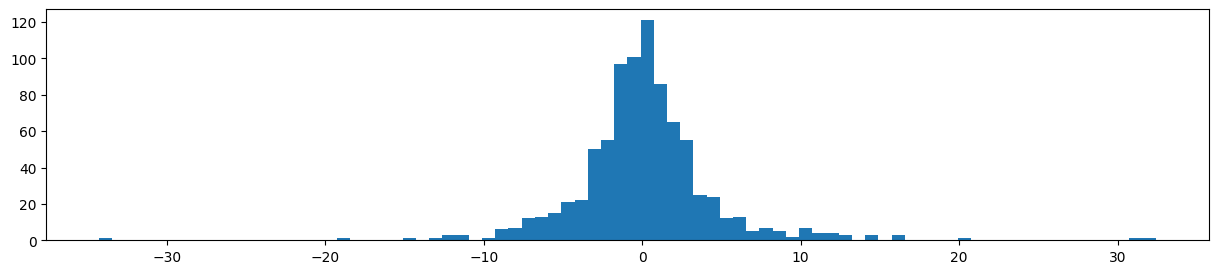

In [23]:
plt.figure(figsize=(15,3))
plt.hist(spread_percentages, bins=80)
plt.show()

In [24]:
pd.Series(open_num_trades).value_counts().sort_index(ascending=False)

6.0      1
5.0     10
4.0     30
3.0     96
2.0    198
1.0    298
0.0    225
Name: count, dtype: int64

In [313]:
pd.Series(spread_percentages).describe()

count    17931.000000
mean         0.178934
std          4.692843
min        -37.850000
25%         -1.970000
50%          0.010000
75%          2.200000
max         78.590000
dtype: float64

In [25]:
spy_per_rates = (prices_with_market[window_size_in_days:window_size_in_days+num_days_to_run]['SPY'].pct_change()*100).cumsum().dropna()
spy_per_rates = spy_per_rates.to_frame()
spy_per_rates

,SPY
date,
2002-01-03,1.133896
2002-01-04,1.801467
2002-01-07,1.095864
2002-01-08,0.864614
2002-01-09,0.049343
...,...
2021-11-03,214.137704
2021-11-04,214.608942
2021-11-05,214.955907


In [26]:
trade_returns = pd.DataFrame({'Date':trade_close_dates, 'Return': spread_percentages})
trade_returns['Return'] = trade_returns['Return']/number_trades_allowed

# Calculate the number of trades per Date
trade_counts = trade_returns.groupby('Date').size().rename('Trade_Count')

return_df = trade_returns.groupby('Date').sum()
return_df = return_df.cumsum()

# Add the trade counts to return_df
return_df = return_df.merge(trade_counts, on='Date', how='left')

return_df

,Return,Trade_Count
Date,,
2002-01-11,0.468667,2
2002-01-23,0.933333,1
2002-02-01,1.386000,2
2002-03-05,1.004667,1
2002-03-14,0.746000,1
...,...,...
2021-09-20,7.616000,1
2021-09-29,7.682667,1
2021-10-08,7.786000,1


In [27]:
merged_df = return_df.combine_first(spy_per_rates)
filled_df = merged_df.ffill()
filled_df

,Return,SPY,Trade_Count
2002-01-03,NaN,1.133896,NaN
2002-01-04,NaN,1.801467,NaN
2002-01-07,NaN,1.095864,NaN
2002-01-08,NaN,0.864614,NaN
2002-01-09,NaN,0.049343,NaN
...,...,...,...
2021-11-03,8.430000,214.137704,4.0
2021-11-04,8.430000,214.608942,4.0
2021-11-05,8.430000,214.955907,4.0
2021-11-08,8.938667,215.041266,2.0


In [28]:
merged_df.Return.isnull().sum()

np.int64(4478)

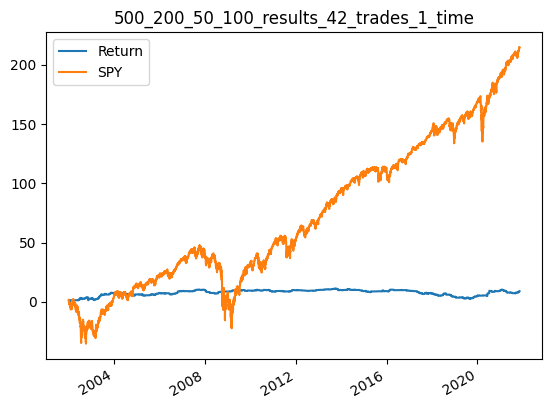

In [29]:
name = '500_200_50_100_results_42_trades_1_time'

filled_df[['Return', 'SPY']].plot()
plt.title(name)
plt.show()

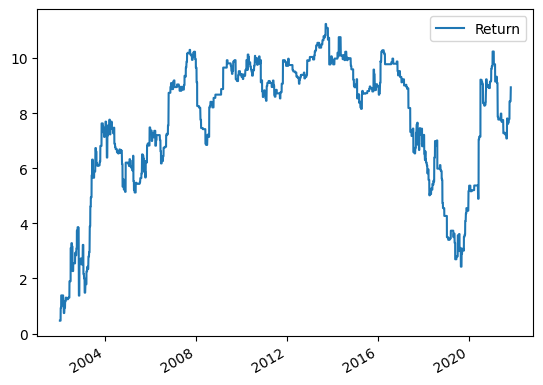

In [30]:
filled_df[['Return']].plot()
plt.show()

In [31]:
pd.DataFrame(results).to_csv(name+'_results'+'.csv')

In [32]:
trade_returns.to_csv(name+'_row_returns'+'.csv')

# Visualization

In [16]:
def construct_periods(start_dates, end_dates):
    periods = []

    min_length = min(len(start_dates), len(end_dates))

    # Pair each start date with the corresponding end date
    for i in range(min_length):
        periods.append((start_dates[i], end_dates[i]))

    # Handle cases where the lists are of unequal length
    if len(start_dates) > len(end_dates):
        # If there are more start dates, pair the remaining ones with None (or a placeholder)
        for j in range(min_length, len(start_dates)):
            periods.append((start_dates[j], None))
    elif len(end_dates) > len(start_dates):
        # If there are more end dates, pair the remaining ones with the last start date
        for j in range(min_length, len(end_dates)):
            periods.append((start_dates[-1], end_dates[j]))

    return periods

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pprint

def print_overall_display(pairs_dictionary, days_ran):
    global prices_with_market

    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = pairs_dictionary

    num_pairs = len(filtered_data)
    num_needed_plots = 0
    if num_pairs % 20 != 0:
        num_needed_plots = num_pairs // 20 + 1
    else:
        num_needed_plots = num_pairs // 20

    # Sort the pairs into chunks for printing 
    indexing_var = 0
    keys = list(filtered_data.keys())
    plotting_dict = {}
    for plot in range(num_needed_plots):
        plotting_dict[f'Plot_{plot+1}'] = []
        for j in range(20):
            if indexing_var >= num_pairs:  # Fix for the off-by-one error
                break
            plotting_dict[f'Plot_{plot+1}'].append(keys[indexing_var])
            indexing_var += 1

    # Iterate over the plotting_dict to create plots
    for plot_name, pairs in plotting_dict.items():
        fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the size as needed
        print(f"Creating {plot_name} with pairs: {pairs}")

        # Get the data for the current set of pairs
        chunk_data = [(key, filtered_data[key]) for key in pairs if key in filtered_data]

        # Iterate over the chunk data to plot
        for idx, (key, value) in enumerate(chunk_data):
            label = f"{key[0]}-{key[1]}"

            # Extract monitoring periods
            periods_start = [str_to_date(date) for date in value['monitoring_start_dates']]
            periods_end = [str_to_date(date) for date in value['monitoring_end_dates']]
            periods = construct_periods(periods_start, periods_end)

            # Plot each period as a line
            for start, end in periods:
                if end is None:
                    # Move 'days_ran' rows forward from the start date to determine the end date
                    start_index = prices_with_market.index.get_loc(start.strftime('%Y-%m-%d'))
                    end_index = start_index + days_ran

                    # Ensure end_index does not exceed the length of the DataFrame
                    if end_index >= len(prices_with_market):
                        end_index = len(prices_with_market) - 1

                    end = prices_with_market.index[end_index]  # Get the string date at end_index
                else:
                    # Convert end to string format for consistency
                    end = end.strftime('%Y-%m-%d')

                ax.plot([start, end], [idx, idx], color='black')

            # Plot open trade dates as green dots
            open_trade_dates = [(str_to_date(date_info[0]), date_info[1], date_info[2], date_info[3], date_info[4]) 
                                for date_info in value['trade_info']['open_trade_dates']]

            if open_trade_dates:
                open_trade_dates_only = [date_info[0] for date_info in open_trade_dates]
                ax.plot(open_trade_dates_only, [idx] * len(open_trade_dates_only), 'o', color='green', label='Open Trade Dates' if idx == 0 else "")

            # Plot close trade dates as red dots
            close_trade_dates = [(str_to_date(date_info[0]), date_info[1], date_info[2]) 
                                 for date_info in value['trade_info']['close_trade_dates']]

            if close_trade_dates:
                close_trade_dates_only = [date_info[0] for date_info in close_trade_dates]
                ax.plot(close_trade_dates_only, [idx] * len(close_trade_dates_only), 'o', color='red', label='Close Trade Dates' if idx == 0 else "")

        # Formatting the plot
        y_labels = [f"{key[0]}-{key[1]}" for key, _ in chunk_data]
        if y_labels:
            ax.set_yticks(range(len(y_labels)))
            ax.set_yticklabels(y_labels, fontsize=10, horizontalalignment='right')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.title(f'Event Timelines for {plot_name}')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [18]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pprint import pprint

def print_trading_with_prices(dict, days_ran):
    global prices_with_market
    
    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = {
        key: value for key, value in dict.items()
        if (value.get('monitoring_start_dates') or value.get('monitoring_end_dates') or
            value.get('trade_info', {}).get('open_trade_dates') or value.get('trade_info', {}).get('close_trade_dates'))
    }
    
    for key in filtered_data:        
        # Safely access trade dates
        open_trade_dates = [item[0] for item in filtered_data[key].get('trade_info', {}).get('open_trade_dates', [])]
        close_trade_dates = [item[0] for item in filtered_data[key].get('trade_info', {}).get('close_trade_dates', [])]

        # Skip processing if there are no open trade dates
        if not open_trade_dates:
            continue  # Skip if there are no open trade dates

        # Determine the start date for plotting
        first_open_trade_date = str_to_date(open_trade_dates[0]) - timedelta(days=20)  # 20 days before

        # Determine the end date for plotting
        if close_trade_dates:
            last_close_trade_date = str_to_date(close_trade_dates[-1]) + timedelta(days=20)  # 20 days after
            try:
                plot_end_loc = prices_with_market.index.get_loc(last_close_trade_date)
            except KeyError:
                # Use the closest available date
                closest_date = prices_with_market.index[prices_with_market.index.get_indexer([last_close_trade_date], method='nearest')[0]]
                plot_end_loc = prices_with_market.index.get_loc(closest_date)
        else:
            # If no close trade dates, use days_ran parameter for the end of the plot
            last_open_trade_date = str_to_date(open_trade_dates[-1])
            try:
                plot_end_loc = prices_with_market.index.get_loc(last_open_trade_date) + days_ran
            except KeyError:
                # Use the closest available date
                closest_date = prices_with_market.index[prices_with_market.index.get_indexer([last_open_trade_date], method='nearest')[0]]
                plot_end_loc = prices_with_market.index.get_loc(closest_date) + days_ran

        # Ensure plot_end_loc does not exceed the length of the DataFrame
        if plot_end_loc >= len(prices_with_market):
            plot_end_loc = len(prices_with_market) - 1

        plot_end_date = prices_with_market.index[plot_end_loc]

        # Adjust plot_start_date to ensure it is within the DataFrame
        plot_start_date = max(prices_with_market.index[0], first_open_trade_date)

        # Plot the relevant prices
        try:
            prices_with_market[[key[0], key[1]]][plot_start_date:plot_end_date].plot()
            plt.title(f"{key}")

            # Prepare trade information for display
            trades_info = []
            num_trades = max(len(open_trade_dates), len(close_trade_dates))
            for i in range(num_trades):
                open_date = open_trade_dates[i]
                try:
                    close_date = close_trade_dates[i]
                    message = filtered_data[key]['trade_info']['close_trade_dates'][i][1]
                except IndexError:
                    close_date = ''
                    message = 'Stock in trade'
                string = f'({open_date}-{close_date}) : {message}'
                trades_info.append(string)    

            # Add vertical green lines for open_trade_dates
            for date in open_trade_dates:
                plt.axvline(x=date, color='green', linestyle='--', linewidth=1)

            # Add vertical red lines for close_trade_dates
            for date in close_trade_dates:
                plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

            plt.show()
            
        except KeyError as e:
            print(f"KeyError: {e} for {key}. Data may be missing.")
        except Exception as e:
            print(f"An error occurred while processing {key}: {e}")


In [19]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def print_spread_with_trading_charts(data_dict, days_ran):
    global prices_with_market
    
    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        if isinstance(date_str, str):
            return datetime.strptime(date_str, '%Y-%m-%d')
        return date_str  # Already a datetime object

    for key in data_dict:
        if not data_dict[key]['trade_info']['open_trade_dates'] or not data_dict[key]['monitoring_start_dates']:
            continue
        
        monitoring_start_dates = data_dict[key]['monitoring_start_dates']
        monitoring_end_dates = data_dict[key]['monitoring_end_dates']
        open_trade_dates = [day[0] for day in data_dict[key]['trade_info']['open_trade_dates']]
        close_trade_dates = [day[0] for day in data_dict[key]['trade_info']['close_trade_dates']]
        
        stock1, stock2 = key
        periods = construct_periods(open_trade_dates, close_trade_dates)
        close_trade_tuples = data_dict[key]['trade_info']['close_trade_dates']

        for period in periods:
            spread_start_date = str_to_date(period[0])  # Ensure this is a datetime object
            if len(period) > 1:
                spread_end_date = str_to_date(period[1]) if period[1] is not None else (spread_start_date + timedelta(days=days_ran))
            else:
                spread_end_date = spread_start_date + timedelta(days=days_ran)

            # Adjust the start date for plotting (5 days before)
            adjusted_start_date = spread_start_date - timedelta(days=5)
            # Adjust the end date for plotting (5 days after)
            adjusted_end_date = spread_end_date + timedelta(days=5)

            # Ensure dates are within the DataFrame range
            try:
                start_loc = prices_with_market.index.get_loc(adjusted_start_date)
            except KeyError:
                start_loc = prices_with_market.index.get_indexer([adjusted_start_date], method='nearest')[0]

            try:
                end_loc = prices_with_market.index.get_loc(adjusted_end_date)
            except KeyError:
                end_loc = prices_with_market.index.get_indexer([adjusted_end_date], method='nearest')[0]

            # Get the actual dates from the DataFrame
            actual_start_date = prices_with_market.index[start_loc]
            actual_end_date = prices_with_market.index[end_loc]

            # Get past three months data
            past_three_months_all_data = prices_with_market.iloc[max(0, start_loc - 89):start_loc + 1]
            past_three_months_data = past_three_months_all_data[[stock1, stock2]]
                
            beta = calculate_beta_for_pair(past_three_months_data, key)
            upper, lower, mean_val = get_spread_limits_for_past_months(past_three_months_data, key, beta)
            
            # Calculate spread using the order of stocks from the key
            price_data = prices_with_market[[stock1, stock2]].loc[actual_start_date:actual_end_date]
            pair_order = [stock1, stock2]  # Define the order based on the key
            spread_data = price_data[pair_order[0]] - beta * price_data[pair_order[1]]
            dates = spread_data.index
            values = spread_data.values

            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.axhline(y=mean_val, color='blue', linestyle='-', linewidth=1, label='Mean for Past 3 months')
            plt.axhline(y=upper, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
            plt.axhline(y=lower, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
            plt.scatter(dates, values, c='black')

            # Add green dots for open-trade dates
            open_trade_dates_dt = [str_to_date(date[0]) for date in data_dict[key]['trade_info']['open_trade_dates']]
            for open_trade_date in open_trade_dates_dt:
                if open_trade_date in dates:
                    plt.scatter(open_trade_date, spread_data.loc[open_trade_date], color='green', s=50, label='Open Trade')

            plt.title(f"Spread data for: {key} for trade: {period}")
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Find the message
            open_date = actual_start_date.strftime('%Y-%m-%d')
            close_date = actual_end_date.strftime('%Y-%m-%d')
            message = 'Stocks currently in trade'
            for tuple in close_trade_tuples:
                if tuple[0] == close_date:
                    message = tuple[1]
            string = f'({open_date}-{close_date}) : {message}'  
            print('Trades: ') 
            print(string)


In [20]:
def print_all_visualizations(dict, days_ran):
    print_overall_display(dict, days_ran)
    print_trading_with_prices(dict, days_ran)
    print_spread_with_trading_charts(dict, days_ran)

In [21]:
# Run Main code
import pprint as pprint
num_days_to_run = 50
window_size_in_days = 180
num_liquid_stocks_to_consider = 30
results, spread_percentages = monitor_pairs(window_size_in_days, num_liquid_stocks_to_consider, num_days_to_run)
pprint.pprint(results)
print(spread_percentages)

----------- Weeks Running: 0 --------------------
----------- Weeks Running: 1 --------------------
Stock pair: ('SDLI', 'NRTLQ'), percentage: 4.17
Stock pair: ('GLW', 'SEBL'), percentage: -9.01
----------- Weeks Running: 2 --------------------
Stock pair: ('CMRCQ', 'BB'), percentage: -0.19
----------- Weeks Running: 3 --------------------
Stock pair: ('CIEN', 'SEBL'), percentage: -1.66
Stock pair: ('ARBA', 'ITWO'), percentage: -2.76
Stock pair: ('AMCC', 'JNPR'), percentage: 2.52
----------- Weeks Running: 4 --------------------
Stock pair: ('CSCO', 'TWX'), percentage: -2.72
----------- Weeks Running: 5 --------------------
Stock pair: ('LVLT', 'MSFT'), percentage: -7.9
Stock pair: ('NTAP', 'ITWO'), percentage: -3.3
Stock pair: ('CIEN', 'SEBL'), percentage: 7.73
----------- Weeks Running: 6 --------------------
Stock pair: ('EXTR', 'AMCC'), percentage: 0.72
----------- Weeks Running: 7 --------------------
Stock pair: ('BRCM', 'ARBA'), percentage: -8.85
Stock pair: ('PMCS', 'VRSN'), pe

In [28]:
# Visualizations 
#print_all_visualizations(results, 50)
#print_overall_display(results, 50)
#print_trading_with_prices(results, 50)
#print_spread_with_trading_charts(results, 50)